<img src='https://storage.googleapis.com/kaggle-datasets-images/228/482/a520351269b547c89afe790820a1087e/dataset-cover.jpeg'>
* ref : kaggle  : https://www.kaggle.com/uciml/pima-indians-diabetes-database
    
    

## Pima Indians Diabetes Database
* Predict the onset of diabetes based on diagnostic measures
* UCI Machine Learning - updated 5 years ago (Version 1)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import Binarizer
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV
from scipy import interp
import warnings
warnings.filterwarnings(action='ignore')

sns.set()

# 데이터 로드

In [2]:
df = pd.read_csv("./diabetes.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.shape

(768, 9)

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


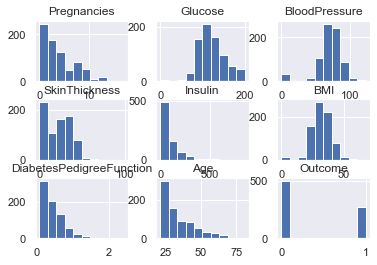

In [6]:
sns.set()
df.hist()
plt.show()

# 우선 점수부터 보자
---------------------------------------
* 1. str X  
* 2. nan

In [7]:
y = df['Outcome']
X = df.drop('Outcome', axis=1)
#----------------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1414,shuffle=False)
#----------------------------------------------------------------------------------------------
model = RandomForestClassifier(n_estimators=500,random_state=1414)  #0.7597402597402597
#----------------------------------------------------------------------------------------------
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.7597402597402597
0.6262626262626263


# 공통함수 

In [8]:
def my_eval_chart(y_val, proba): 
    # --------------- 양성 평가를 위한 차트 : precision_recall_curv() -------------------    
    # plot_precision_recall_curve(model, 문제지2, 정답지2)
    precisions, recalls, ths = precision_recall_curve(y_val, proba[:, 1])
    plt.title("precision recall curv %0.4f"% f1)
    # plt.title(f"precision recall curv %0.4f" % f1)
    plt.xlabel("threadhold")
    plt.ylabel("value")
    plt.plot(ths, precisions[:ths.shape[0]], "b", label="precision")
    plt.plot(ths, recalls[:ths.shape[0]], "r", linestyle='--', label="recall")
    plt.grid()
    plt.legend()
    plt.show()

    # --------------- 양성 평가를 위한 차트 : roc_auc_score(), roc_curve() -------------------
    auc_score = roc_auc_score(y_val, proba[:, 1])

    fprs, tprs, ths = roc_curve(y_val, proba[:, 1])
    plt.title("roc curv %0.4f" % auc_score)
    # plt.title(f"precision recall curv %0.4f" % f1)
    plt.xlabel("FPR(1-specificity)")
    plt.ylabel("TPR")
    plt.grid()
    plt.plot(fprs, tprs, "b")
    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.show()

            
def my_eval(y_val, pred, proba, chart=False):  #avg='binary'
    accuracy = accuracy_score(y_val, pred)
    precision = precision_score(y_val, pred)
    recall = recall_score(y_val, pred)
    f1 = f1_score(y_val, pred)
    matrix = confusion_matrix(y_val, pred)
    print(f'정확도{accuracy:.4f} 정밀도:{precision:.4f} 재현률:{recall:.4f} f1:{f1:.4f}')
    print("오차행렬\n", matrix)
    # cls_report = classification_report(y_val, pred)    
    if chart==True:
        my_eval_chart(y_val, proba)

def fit_score(X_train, X_test, y_train, y_test, model=None, test_size=0.2):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)                                        #[0  1]              th:0.5
    proba = model.predict_proba(X_test)                                 #[[.7 >.3] [.4  <.6]]  --> [0  1]
    my_eval(y_test, pred, proba) 


# EDA & Engineering
* 이상치 데이터 : 0 
* 왜도(skew) : 정규분포화, 표준화

In [9]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [10]:
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']

In [11]:
#df[Glucose==0][Glucose]
print(df[df['Glucose']==0]['Glucose'].count(), df[df['Glucose']!=0]['Glucose'].count())

5 763


In [12]:
for COL in zero_cols:
    print(COL, df[df[COL]==0][COL].count()/df.shape[0]*100, df[df[COL]!=0][COL].count()/df.shape[0]*100) 

Glucose 0.6510416666666667 99.34895833333334
BloodPressure 4.557291666666666 95.44270833333334
SkinThickness 29.557291666666668 70.44270833333334
Insulin 48.69791666666667 51.302083333333336
BMI 1.4322916666666665 98.56770833333334


####  zero_cols : (0/1   &  나이구간별) 평균 --> 0 채우기

In [13]:
df['BloodPressure'].mean()

69.10546875

In [14]:
df['Age'].describe() 

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

In [15]:
df['Age'].describe() 
#min : 21 ~ max : 81   --> 20 30 40 50 60 70 80 
# df['Age_band'] = df['Age']//20

df['Age_band'] = pd.cut(df['Age'], bins=[0,20,24,29,41,82,150],labels=[0,1,2,3,4,5] )
df[['Age','Age_band']].head() 
df['Age_band'].unique()

[4, 3, 1, 2]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

In [16]:
# select Age_band, avg(BloodPressure) from emp group by Age_band;
# df[조건].groupby()[컬럼]  Glucose
df[df['BloodPressure']>0].groupby(['Outcome','Age_band'])['BloodPressure'].mean()

Outcome  Age_band
0        0                 NaN
         1           66.839779
         2           70.203390
         3           73.574257
         4           77.518519
         5                 NaN
1        0                 NaN
         1           71.586207
         2           71.250000
         3           74.149425
         4           79.931818
         5                 NaN
Name: BloodPressure, dtype: float64

In [17]:
for COL in zero_cols:
    print(COL,  df[df[COL]>0].groupby(['Outcome','Age_band'])[COL].mean())
    print("---"*10)

Glucose Outcome  Age_band
0        0                  NaN
         1           107.594595
         2           107.451613
         3           113.133333
         4           119.060241
         5                  NaN
1        0                  NaN
         1           141.064516
         2           140.396226
         3           143.430108
         4           142.741573
         5                  NaN
Name: Glucose, dtype: float64
------------------------------
BloodPressure Outcome  Age_band
0        0                 NaN
         1           66.839779
         2           70.203390
         3           73.574257
         4           77.518519
         5                 NaN
1        0                 NaN
         1           71.586207
         2           71.250000
         3           74.149425
         4           79.931818
         5                 NaN
Name: BloodPressure, dtype: float64
------------------------------
SkinThickness Outcome  Age_band
0        0                

### 이상값(0) 채우기
* Insulin        : Outcome  Age_band
* BloodPressure  : Outcome  Age_band
* Glucose        : Outcome  Age_band
---
* BMI           : Outcome
* SkinThickness : Outcome



In [18]:
df[zero_cols] = df[zero_cols].replace(0, np.nan)
# df.fillna(  df[zero_cols].transpose( _____ )   )
# df.isna().sum()

In [19]:
df["Insulin"]       = df["Insulin"].fillna(df.groupby(by=["Outcome","Age_band"])["Insulin"].transform('mean'))
df["BloodPressure"] = df["BloodPressure"].fillna(df.groupby(by=["Outcome","Age_band"])["BloodPressure"].transform('mean'))
df["Glucose"]       = df["Glucose"].fillna(df.groupby(by=["Outcome","Age_band"])["Glucose"].transform('mean'))

df["BMI"]           = df["BMI"].fillna(df.groupby(by="Outcome")["BMI"].transform('mean'))
df["SkinThickness"] = df["SkinThickness"].fillna(df.groupby(by="Outcome")["SkinThickness"].transform('mean'))

In [20]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Age_band                    0
dtype: int64

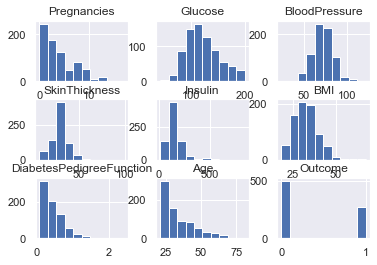

In [21]:
df.hist()
plt.show()

# 상관분석

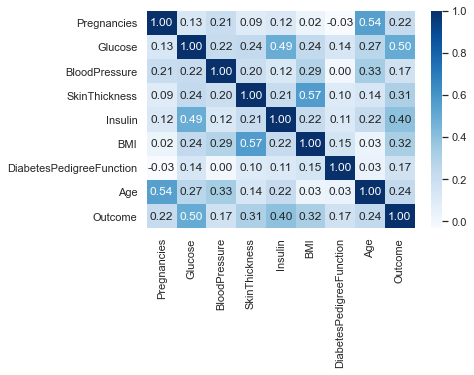

In [22]:
sns.heatmap(df.corr(), fmt=".2f", annot=True, cmap="Blues")
plt.show()

# Outlier는 train을 대상으로만 한다 
* train_test_split으로 df를 분리

In [23]:
#-------------------가공처리를 끝낸 DataFrame을 사용해 스케일링-----------------------------------
y = df['Outcome']
X = df.drop('Outcome', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1414,shuffle=False)
#----------------------------------------------------------------------------------------------

In [24]:
X.shape, y.shape, X_train.shape, X_test.shape

((768, 9), (768,), (614, 9), (154, 9))

# 1차 점수 확인 : 이상치 제거

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcAqc6V%2FbtqyQLiddUd%2FiXQVu1nYTo2rx3Q8xZBqy0%2Fimg.png" width=400 height=400>

In [25]:
X_train[['Glucose','Insulin', 'Age']].describe()

,Glucose,Insulin,Age
count,614.000000,614.000000,614.000000
mean,121.440788,156.641748,33.197068
std,30.866709,91.279970,11.772805
min,44.000000,14.000000,21.000000
25%,99.000000,115.873239,24.000000
50%,116.500000,139.250000,29.000000
75%,141.000000,178.756098,40.000000
max,198.000000,846.000000,81.000000


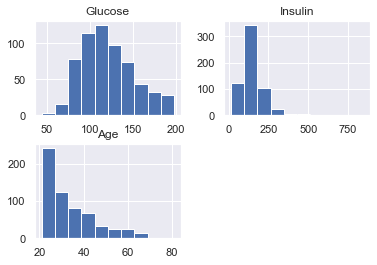

In [26]:
X_train[['Glucose','Insulin', 'Age']].hist()
plt.show()

count    131.000000
mean       4.687023
std        3.147854
min        1.000000
25%        2.000000
50%        4.000000
75%        6.500000
max       15.000000
Name: Glucose, dtype: float64


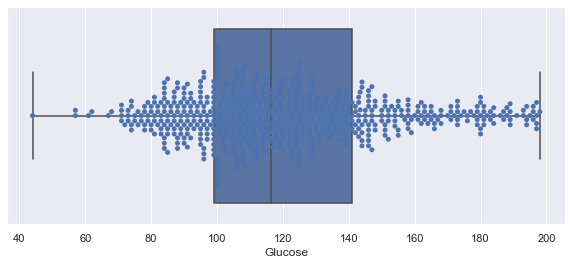

In [27]:
print(X_train['Glucose'].value_counts().describe())
f,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=X_train['Glucose'])
sns.swarmplot(x=X_train['Glucose'])
plt.show()

count    174.000000
mean       3.528736
std        8.096012
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       53.000000
Name: Insulin, dtype: float64


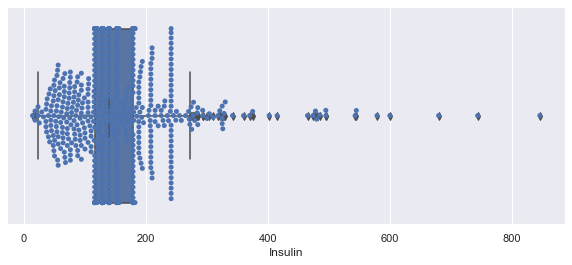

In [28]:
print(X_train['Insulin'].value_counts().describe())
f,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=X_train['Insulin'])
sns.swarmplot(x=X_train['Insulin'])
plt.show()

count    50.000000
mean     12.280000
std      12.834965
min       1.000000
25%       3.000000
50%       7.500000
75%      16.500000
max      53.000000
Name: Age, dtype: float64


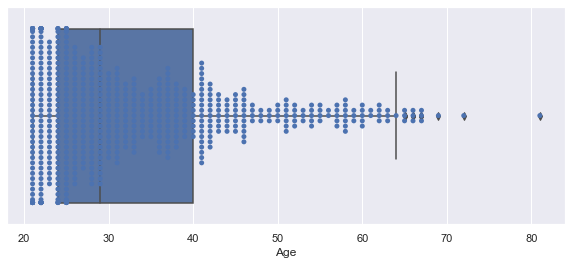

In [29]:
print(X_train['Age'].value_counts().describe())
f,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=X_train['Age'])
sns.swarmplot(x=X_train['Age'])
plt.show()

## outlier 수식으로 찾기
* Glucose< 20 
* Insulin > 620
* Age > 80 

In [30]:
Glucose_idx = X_train[ X_train['Glucose'] < 20 ].index.values   
Insulin_idx = X_train[ X_train['Insulin'] > 620 ].index.values   
Age_idx     = X_train[ X_train['Age'] > 80 ].index.values  

print(Glucose_idx, Insulin_idx, Age_idx)

[] [ 13 228 247] [459]


In [31]:
X_train.shape, X_test.shape

((614, 9), (154, 9))

In [32]:
for idx in Glucose_idx:
    X_train.drop(index=idx, inplace=True)
    y_train.drop(index=idx, inplace=True)

for idx in Insulin_idx:
    X_train.drop(index=idx, inplace=True)
    y_train.drop(index=idx, inplace=True)
    
X_train.drop(index=Age_idx, inplace=True)
y_train.drop(index=Age_idx, inplace=True)

In [33]:
X_train.shape, X_test.shape

((610, 9), (154, 9))

In [34]:
aa= pd.concat([X_train, X_test])
aa.reset_index(drop=True,inplace=True)
bb= pd.concat([y_train, y_test])
bb.reset_index(drop=True,inplace=True)
aa.head()
X_train, X_test, y_train, y_test = train_test_split(aa, bb,test_size=0.2,random_state=1414,shuffle=False)

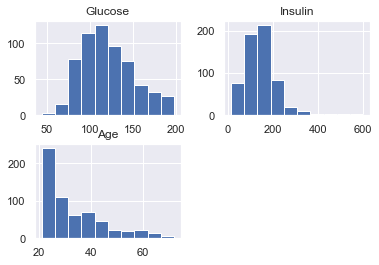

In [35]:
X_train[['Glucose','Insulin', 'Age']].hist()
plt.show()

In [36]:
fit_score(X_train, X_test, y_train, y_test, model)  

정확도0.8497 정밀도:0.8039 재현률:0.7593 f1:0.7810
오차행렬
 [[89 10]
 [13 41]]


## 방법2)  outlier IQR 범위로 찾기

In [37]:
def my_detect_outliers(df, features, r=1.5): 
    dict = {}
    for col in features: 
        Q1 = np.percentile(df[col], 25) #2.5
        Q3 = np.percentile(df[col], 75) #7.5
        IQR = Q3 - Q1                   #5
        minimum = Q1 - (r * IQR)   #-5
        maximum = Q3 + (r * IQR)   #15
        idxs = df[  (df[col]<minimum) | (df[col]>maximum)  ].index 
        dict[col] = idxs
    return dict

In [38]:
# #-------------------가공처리를 끝낸 DataFrame을 사용해 스케일링-----------------------------------
# y = df['Outcome']
# X = df.drop('Outcome', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1414,shuffle=False)
# #----------------------------------------------------------------------------------------------

In [39]:
# res_dict = my_detect_outliers(X_train, ['Glucose','Insulin', 'Age'])
# print(res_dict)

In [40]:
# for idx in res_dict['Glucose']:
#     X_train.drop(index=idx, inplace=True)
#     y_train.drop(index=idx, inplace=True)

# for idx in res_dict['Insulin']:
#     X_train.drop(index=idx, inplace=True)
#     y_train.drop(index=idx, inplace=True)


# for idx in res_dict['Age']:
#     X_train.drop(index=idx, inplace=True)
#     y_train.drop(index=idx, inplace=True)    

In [41]:
# X_train[['Glucose','Insulin', 'Age']].hist()
# plt.show()

In [42]:
# fit_score(X_train, X_test, y_train, y_test, model)  

# 2차 점수 확인 : 스케일링

### 스케일링 : 정규화, 단위맞추기

In [43]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [44]:
scaler_X_train = X_train
scaler_X_test = X_test
scalers = StandardScaler() #, RobustScaler(), MinMaxScaler()]
scalers.fit(X_train[X_test.columns])
scaler_X_train[X_test.columns] = scalers.transform(X_train[X_test.columns])
scaler_X_test[X_test.columns] = scalers.transform(X_test[X_test.columns])

In [45]:
scaler_X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Age_band
611,-0.243138,-0.494911,-0.001677,-0.207006,-0.469187,-0.943433,-0.825321,-0.528079,-0.371308
612,0.651787,-0.135375,2.004328,-0.207006,-0.020597,-0.524498,-0.977292,-0.269402,0.532554
613,-0.541447,-1.736944,-0.837513,-1.761089,-1.715990,-1.766857,-0.673350,-0.872981,-1.275170
614,1.546712,-0.298801,0.834159,-0.560220,1.080405,-0.596729,2.442062,1.455109,1.436416
615,-1.138064,-0.070005,-0.036263,0.422309,0.426168,0.010005,-1.025923,-0.786755,-1.275170


In [46]:
scaler_X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Age_band
0,0.651787,0.877862,-0.001677,0.640649,1.080405,0.183357,0.451238,1.455109,1.436416
1,-0.839755,-1.181298,-0.503178,-0.014371,-0.020597,-0.827865,-0.387644,-0.183176,0.532554
2,1.248404,2.021840,-0.670345,0.422309,0.308050,-1.304584,0.588012,-0.096951,0.532554
3,-0.839755,-1.050557,-0.503178,-0.669390,-0.739543,-0.611175,-0.946898,-1.045432,-1.275170
4,-1.138064,0.518326,-2.676351,0.640649,0.175104,1.555730,5.499724,-0.010725,0.532554


# 3차 점수 확인 : 모델변경

### 모델 변경 : Boost 계열

In [47]:
import xgboost as xgb
# import lightgbm

In [48]:
xgmodel = xgb.XGBClassifier(n_estimators=300, objective="binary:logistic")   #logloss 
fit_score(scaler_X_train, scaler_X_test, y_train, y_test, xgmodel)   #0.8441558441558441   

[21:24:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
정확도0.8824 정밀도:0.8600 재현률:0.7963 f1:0.8269
오차행렬
 [[92  7]
 [11 43]]


# 4차 점수확인 : 검증
* 교차 검증(cross_val_score) : 데이터 N배 증강시켜 순차적 학습, (점수)
* 폴드(KFold, StratifiedKFold)  : 데이터 N배 증강시켜 순차적 학습, (점수,과정)
* 그리드서치(GridSearch)***   : 데이터 N배 증강시켜 순차적 학습,  (점수, 과정, 모델튜닝)

## <font color='red'>전체 데이터를 주자 </font>

In [49]:
print(type(scaler_X_train), type(y_train))  # <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>

scaler_X = np.concatenate([scaler_X_train, scaler_X_test])
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)
print(scaler_X.shape, y.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(764, 9) (764,)


### 폴드 KFold(), StratifiedKFold()

In [50]:
from sklearn.model_selection import KFold, StratifiedKFold

accuracy_total_score = []
f1_total_score = []
auc_total_score = []

# kfold = KFold(n_splits=5, random_state=1414, shuffle=True)
# for train_index, test_index in kfold.split(문제지):

skfold = StratifiedKFold(n_splits=5, random_state=1414, shuffle=True)
for train_index, test_index in skfold.split(scaler_X, y):
    문제지8, 문제지2 = scaler_X[train_index], scaler_X[test_index]
    정답지8, 정답지2 = y[train_index], y[test_index]
   #train_test_split(문제지,정답지, test_sizse=0.2, random_state=1414, shuffle=False) ----
    model.fit(문제지8, 정답지8)
    pred = model.predict(문제지2)
    proba = model.predict_proba(문제지2)
    
    accuracy = accuracy_score(정답지2, pred)
    f1 = f1_score(정답지2, pred)
    auc = roc_auc_score(정답지2, proba[:, 1])
    
    accuracy_total_score.append(accuracy)
    f1_total_score.append(f1)
    auc_total_score.append(auc)
    ####return np.array(total_score)

# print("평균", sum(accuracy_total_score) / len(accuracy_total_score))
print("평균 정확도 : ", np.array(accuracy_total_score).mean())  #평균 0.8658772599949071
print("평균 F1 :", np.array(f1_total_score).mean())  
print("평균 AUC :", np.array(auc_total_score).mean())  
 

평균 정확도 :  0.8638458892328862
평균 F1 : 0.8023654015887025
평균 AUC : 0.9289153237476089


### cross_val_score()

In [51]:
from sklearn.model_selection import cross_val_score
#scores : ndarray  ::: 위와상동 == np.array(total_score)
total_score = cross_val_score(model, scaler_X, y, scoring='f1', cv=5)  #n_splits=cv=5
print(total_score)  #평균 0.8658772599949071
print("cross_val_score 평균:", total_score.mean())  #평균 0.867

[0.8        0.81904762 0.80769231 0.83809524 0.77669903]
cross_val_score 평균: 0.8083068387922758


# 5차 점수확인 : 임계치 조정을 통한  f1_score() 올리기

### confusion_matrix 
* ref : https://www.medcalc.org/manual/roc-curves.php
| | |
|:-|:-|
|TN|FP|
|FN|TP|

| | | |
|-|:-|:-|
|정확도|$accuracy=\frac{TN+TP}{TP+FP+FP+FN}$|전체 샘플 중 맞게 예측한 비율|
|정밀도|$precision=\frac{TP}{TP+FP}$|True로 예측한것 중 실제 True인 비율|
|재현률|$recall=\frac{TP}{FN+FP}$|실제 True 중 예측이 True인 비율|
|F1|$f1=2*\frac{precision * recall}{precision + recall}$|정밀도 재현율 조화 평균|

* 재현율(recall) 점수 올리기
<pre>
th:2  --> th:1     [임계치를 낮추면]
[0 1 1]-->[1 1 1]  즉 양성 데이터가 늘었다 --> 24수치를 줄인다
*
[[86 13] <br>
 [24 31]]
</pre>

In [52]:
proba = model.predict_proba(scaler_X_test)   #이미 학습에서 사용된 데이터 100점...공모전의 테스트데이터를 넣어라..
th_list = [0.4,  0.5, 0.6]
for th in th_list:
    binz = Binarizer(threshold=th)                              # [[.7 .3] [.4  .6]]   th:0.2
    pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))   # [  th<.3] [  th<.6]]  --> [1 1]
    f1 = f1_score(y_test, pred_binz)
    auc = accuracy_score(y_test, pred_binz)
    #my_eval(y_test, pred_binz, proba, th)        

    print("f1_score:",f1)
    print("accuracy_score:", auc)   

f1_score: 0.9259259259259259
accuracy_score: 0.9477124183006536
f1_score: 0.9259259259259259
accuracy_score: 0.9477124183006536
f1_score: 0.9433962264150944
accuracy_score: 0.9607843137254902


In [53]:
# 임계치 : 0.35 기준 
# f1:0.6780
# accuracy : 0.7532 

# 6차 점수확인: GridSearchCV / 미완성 지워도됨... 각자에게 맡깁니다...

In [54]:
# scaler_X_train, scaler_X_test, y_train, y_test

In [55]:
X = pd.concat([scaler_X_train,scaler_X_test ])
y = pd.concat([y_train, y_test])
print(X.shape, y.shape)

(764, 9) (764,)


In [60]:
random_state=42

fit_params = {"eval_metric" : 'f1', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 50}

param_test = {'learning_rate' : [0.01, 0.02, 0.05, 0.1],
              'n_estimators' : [100, 300, 1000]}

#number of combinations
n_jobs = 10

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=5)
grid_search = GridSearchCV(
    estimator=lgbm_clf, param_grid=param_test, 
    n_jobs=n_jobs,
    scoring='f1',
    cv=5,
    refit=True,
    )

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)
grid_search.best_score_

0.8350248580455343

In [61]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 100}

param_test = {'learning_rate' : [0.01, 0.02, 0.05, 0.1],
              'n_estimators' : [100, 300, 1000]}

#number of combinations
n_jobs = 10

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=5)
grid_search = GridSearchCV(
    estimator=lgbm_clf, param_grid=param_test, 
    n_jobs=n_jobs,
    scoring='accuracy',
    cv=5,
    refit=True,
    )

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.985923
[200]	valid's auc: 0.999141
[300]	valid's auc: 1
[400]	valid's auc: 1
[500]	valid's auc: 1
[600]	valid's auc: 1
[700]	valid's auc: 1
[800]	valid's auc: 1
[900]	valid's auc: 1
[1000]	valid's auc: 1
Did not meet early stopping. Best iteration is:
[277]	valid's auc: 1


# 7차 OPTUNA : 하이퍼 파라미터 최적화 API / 공부용

In [ ]:
# # 1 objective function
# # 2 hyperparameter values using trial object. 
# import optuna
# def my_objective(trial):
#     myparam = {
#     "min_samples_split" : trial.suggest_int('min_samples_split', 1,3),
#     "max_depth" : trial.suggest_uniform('max_depth', 1, 20),
#     }
#     model = RandomForestClassifier(**myparam)
#     model.fit(X_train, y_train)
#     pred = model.predict(X_test)
#     proba = model.predict_proba(X_test)
#     score = log_loss(y_test, proba)
#     return score

# # 3  Create a study object and invoke the optimize method over 100 trials
# study = optuna.create_study()
# study.optimize(my_objective, n_trials=30)
# best_param = study.best_params
# print(study.best_params)

# # 4 best_param 적용
# model = RandomForestClassifier(**best_param)
# model.fit(X_train, y_train)
# pred = model.predict(X_test)
# proba = model.predict_proba(X_test)
# score = log_loss(y_test, proba)
# print(score)
